In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model Training

In the original paper, they used k-folds during testing since the data is very minimal.
- The custom data set will have 2 modes: **train** and **test**. We'll apply k-folds to the train mode, to generate the train and validation sets. And the test mode, to generate the test set. This test set will never be used during training.

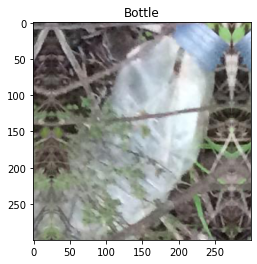

In [ ]:
from torch.utils.data import Dataset
import json
import cv2 as cv
from math import floor
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torchvision.transforms as T
from PIL import Image

# Custom Dataset Class
class TacoDataset(Dataset):
    def __init__(self, mode="train", transforms=T.Compose([])):
        # Path Variables
        dataset = "TACO-3"
        dir_path = '/content/drive/MyDrive/data/TACO/'

        # Read dataset file
        dataset_path = dir_path + "train_" + dataset + ".csv" if mode == "train" else dir_path + "test_" + dataset + ".csv"
        with open(dataset_path, 'r') as f:
            self.data = pd.read_csv(f)

        # Category Id to to Category Name Mapping
        self.cat_id2name = self.data[['supercat_id', 'supercategory']].drop_duplicates()

        # Image Transforms
        self.transforms = transforms

    def __getitem__ (self, idx):
        # read image file
        imgs_filepath = '/content/drive/MyDrive/data/TACO/'
        img = Image.open(imgs_filepath + self.data.iloc[idx]['file_name'])

         # crop image based on bounding box
        bbox = self.data.iloc[idx]['bbox'][1:-1]
        bbox = bbox.split(',')
        left, top, right, bottom = float(bbox[0]), float(bbox[1]), float(bbox[0])+float(bbox[2]), float(bbox[1])+float(bbox[3])
        img1 = img.crop((left,top,right,bottom))
        # print(f"img.size: {img.size} | img1.size: {img1.size}")

        # resize image
        img1 = T.functional.resize(img1, size=299, max_size=300)
        w,h = img1.size
        h_padding = (300 - w) / 2
        v_padding = (300 - h) / 2
        lp = h_padding if h_padding % 1 == 0 else h_padding+0.5
        tp = v_padding if v_padding % 1 == 0 else v_padding+0.5
        rp = h_padding if h_padding % 1 == 0 else h_padding-0.5
        bp = v_padding if v_padding % 1 == 0 else v_padding-0.5

        img1 = T.functional.pad(img1, padding=(int(lp), int(tp), int(rp), int(bp)), padding_mode='reflect')

        # apply transformations
        img2 = self.transforms(img1)

        # get classificaation
        cat_id = self.data.iloc[idx]['supercat_id']

        return img2, cat_id

    def __len__(self):
        return len(self.data)

transforms = T.Compose([T.Resize((300,300))
                       ,T.RandomVerticalFlip(0.5)
                       ,T.RandomHorizontalFlip(0.5)
                       #,T.RandomRotation(45)
                       ])
temp_dataset = TacoDataset(mode="train", transforms=transforms)

# print(temp_dataset.dataset_df)
# print(temp_dataset.cat_id2name)

img, label = temp_dataset[0]
plt.imshow(img)
plt.title(temp_dataset.cat_id2name[temp_dataset.cat_id2name['supercat_id'] == label]['supercategory'].values[0])
plt.show()

## Datasets

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torchvision.transforms as T

# Transforms
train_transforms = T.Compose([T.Resize((300,300))
                       ,T.RandomVerticalFlip(0.5)
                       ,T.RandomHorizontalFlip(0.5)
                       #,T.RandomRotation(45)
                       ,T.ToTensor()])
test_transforms = T.Compose([T.Resize((1024,1024)), T.ToTensor()])

# Datasets
train_dataset = TacoDataset(mode="train", transforms=train_transforms)
test_dataset = TacoDataset(mode="test", transforms=test_transforms)
print(f"Number of training data: {len(train_dataset)}")
print(f"Number of test data: {len(test_dataset)}")

Number of training data: 678
Number of test data: 226


### View data in one mini batch

torch.Size([3, 1024, 1024])
6


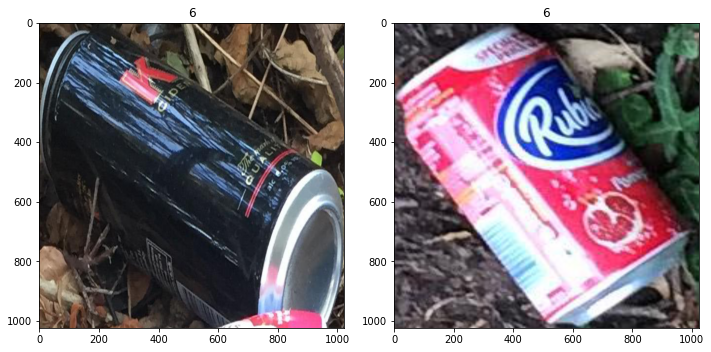

In [ ]:
import torchvision

temp_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

for i, mini_batch in enumerate(temp_dataloader):
    if i == 1:
        img1, img2 = mini_batch[0]
        label1, label2 = mini_batch[1]
        print(img1.shape)
        print(label1.item())

        fig, axes = plt.subplots(1,2, figsize=(10,10))
        axes[0].imshow(img1.permute(1,2,0))
        axes[0].set_title(label1.item())

        axes[1].imshow(img2.permute(1,2,0))
        axes[1].set_title(label2.item())
        break

plt.tight_layout()
plt.show()

### View all the cropped images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  # This is added back by InteractiveShellApp.init_path()


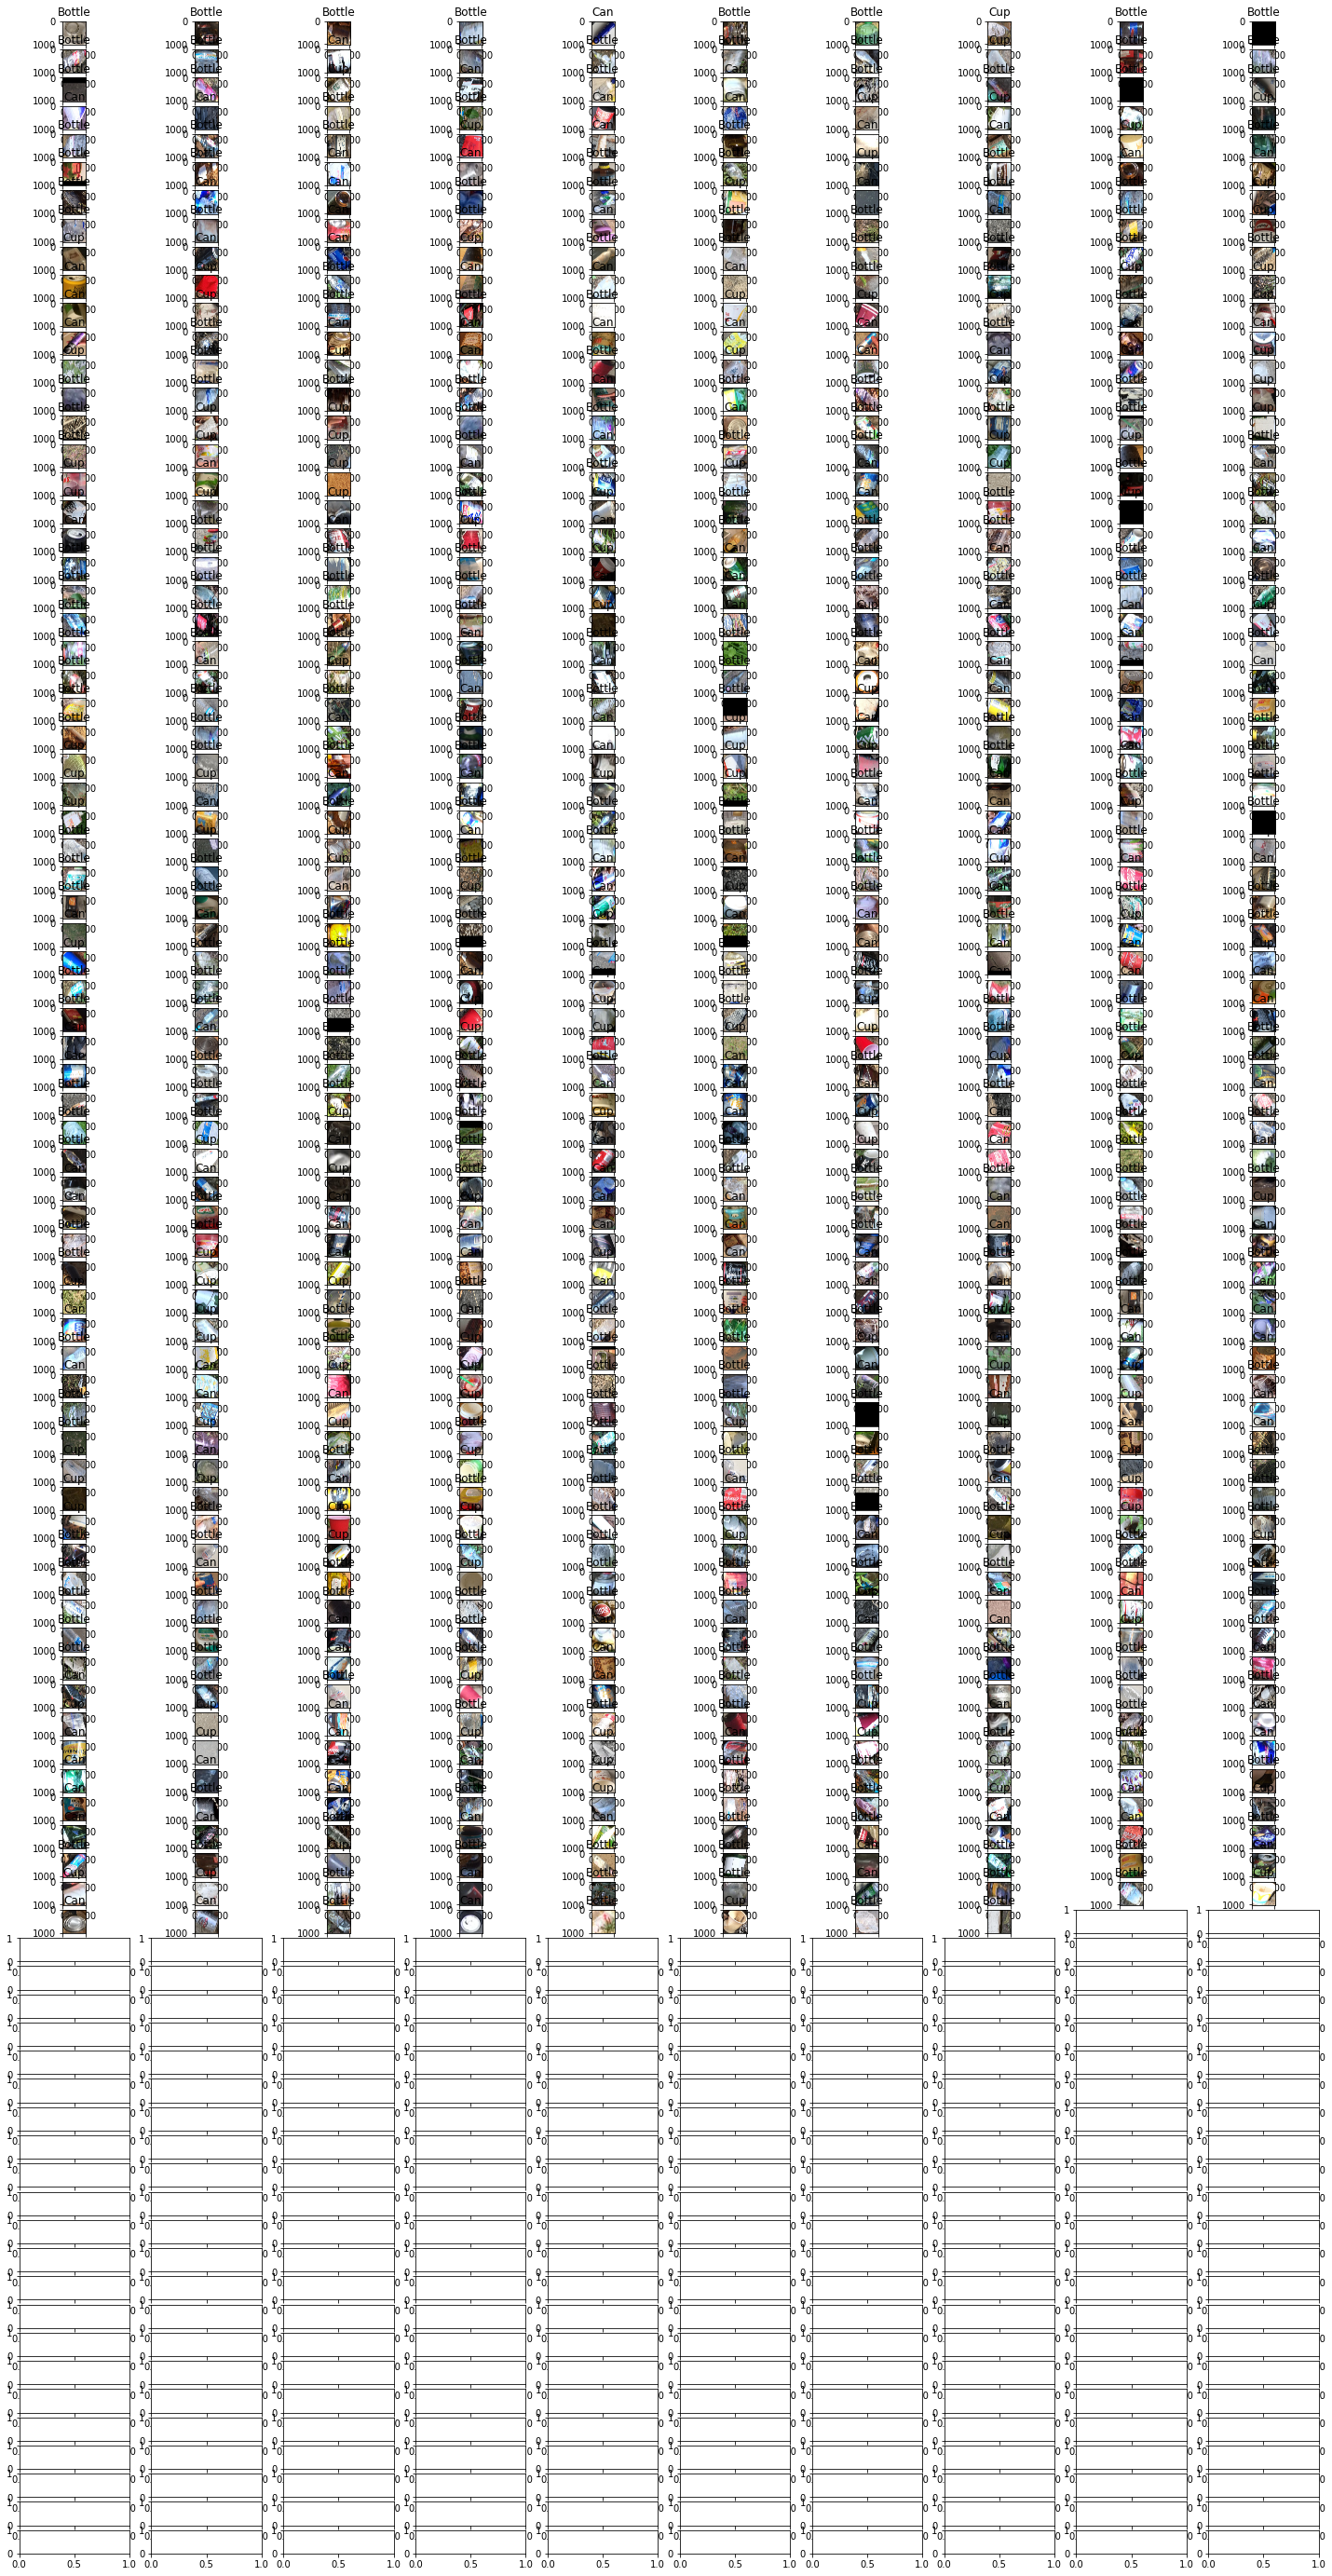

In [ ]:
import torchvision

temp_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

fig, axes = plt.subplots(70,10, figsize=(100,50))
for i, mini_batch in enumerate(temp_dataloader):
    for j in range(len(mini_batch[0])):
        img, label = mini_batch[0][j], mini_batch[1][j].item()
        axes[i][j].imshow(img.permute(1,2,0))
        axes[i][j].set_title(train_dataset.cat_id2name[train_dataset.cat_id2name['supercat_id'] == label].supercategory.item())
plt.tight_layout()
plt.show()

## Display one image per label

In [ ]:
temp_dataset.cat_id2name

,supercat_id,supercategory
0,3,Bottle
329,6,Can
534,8,Cup


[3 6 8]
looking image with label: 3
looking image with label: 6
looking image with label: 8
Images: [<PIL.Image.Image image mode=RGB size=272x328 at 0x7F515BB1D5D0>, <PIL.Image.Image image mode=RGB size=93x88 at 0x7F5159E5BF50>, <PIL.Image.Image image mode=RGB size=235x234 at 0x7F5159E554D0>]
Labels: [3, 6, 8]


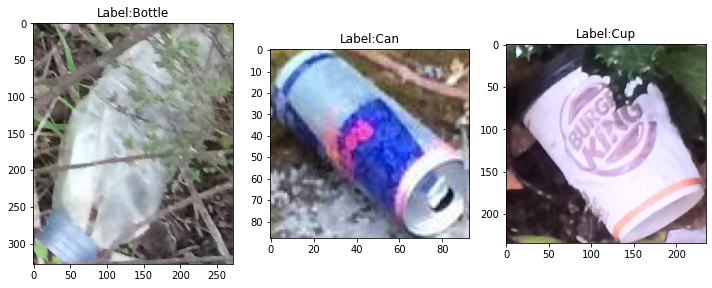

In [ ]:
# display one image per label

temp_dataset = TacoDataset()
imgs = []
labels = []

# get an image for each super category
supercats = temp_dataset.data.supercat_id.drop_duplicates().values
print(supercats)
for category in supercats:
    print(f"looking image with label: {category}")
    for i in range(len(temp_dataset)):
        img, cat_id = temp_dataset[i]
        if cat_id == category:
            imgs.append(img)
            labels.append(cat_id)
            break

print("Images:", imgs)
print("Labels:", labels)

fig, axes = plt.subplots(1,len(supercats), figsize=(10,10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    axes[i].imshow(img)
    axes[i].set_title(f"Label:{temp_dataset.cat_id2name[temp_dataset.cat_id2name.supercat_id == label].supercategory.values[0]}")
plt.tight_layout()
plt.show()

Split the Dataset

The original paper proposed a TACO-10 dataset, which contains the top 9 classes and an extra class 'Other'

## Model

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.cuda as cuda

model = models.efficientnet_v2_m(weights="EfficientNet_V2_M_Weights.DEFAULT") # model with pre-trained weights
in_features = model.classifier[1].in_features

num_categories = train_dataset.data.supercategory.nunique()
model.classifier[1] = nn.Linear(in_features, num_categories)
print(f"# of categories: {num_categories}")

for child in model.children():
  for param in child.parameters():
    param.required_grad = False

model.classifier[1].requires_grad = True

device = 'cuda' if cuda.is_available() else 'cpu'
model = model.to(device)
print(f"device:{device}")

# of categories: 3
device:cuda


## Training

## Simple Train - Validation Split

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from math import ceil

EPOCHS = 5
BATCHSIZE = 16
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss(reduction = 'mean') # cross entropy loss function for classification
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE) # stochastic gradient descent with learning rate of 0.0001

# initialize training losses
# train_losses = []

train_dataloader = DataLoader(train_dataset, BATCHSIZE, shuffle=True)
valid_dataloader = DataLoader(test_dataset, BATCHSIZE)

num_batches = len(train_dataloader)
num_data = len(train_dataset)
print(f"# of batches: {num_batches}")
print(f"# of data: {num_data}")

for e in range(EPOCHS):
    # set model to train mode
    model.train()

    for b,(X,y) in enumerate(train_dataloader):
        # send the data to device(gpu)
        X, y = X.to(device), y.to(device)

        # generate predictions and compute the loss
        y_pred = model(X)
        train_loss = criterion(y_pred,y)

        # update the weights
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # save loss
        train_losses.append(train_loss.item())

        if b%10 == 0:
            print(f"Epoch {e+1:2} | Batch {b+1:3} | Loss = {train_loss.item():0.4f}")

# of batches: 43
# of data: 678
Epoch  1 | Batch   1 | Loss = 0.2482
Epoch  1 | Batch  11 | Loss = 0.2675
Epoch  1 | Batch  21 | Loss = 0.3808
Epoch  1 | Batch  31 | Loss = 0.3475
Epoch  1 | Batch  41 | Loss = 0.2580
Epoch  2 | Batch   1 | Loss = 0.2437
Epoch  2 | Batch  11 | Loss = 0.5035
Epoch  2 | Batch  21 | Loss = 0.5008
Epoch  2 | Batch  31 | Loss = 0.3866
Epoch  2 | Batch  41 | Loss = 0.4723
Epoch  3 | Batch   1 | Loss = 0.4013
Epoch  3 | Batch  11 | Loss = 0.1947
Epoch  3 | Batch  21 | Loss = 0.2229
Epoch  3 | Batch  31 | Loss = 0.6895
Epoch  3 | Batch  41 | Loss = 0.5259
Epoch  4 | Batch   1 | Loss = 0.3757
Epoch  4 | Batch  11 | Loss = 0.4439
Epoch  4 | Batch  21 | Loss = 0.2957
Epoch  4 | Batch  31 | Loss = 0.4224
Epoch  4 | Batch  41 | Loss = 0.4172
Epoch  5 | Batch   1 | Loss = 0.2642
Epoch  5 | Batch  11 | Loss = 0.2651
Epoch  5 | Batch  21 | Loss = 0.4038
Epoch  5 | Batch  31 | Loss = 0.3382
Epoch  5 | Batch  41 | Loss = 0.2377


## K-Folds

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from math import ceil

EPOCHS = 5
BATCHSIZE = 2
LEARNING_RATE = 0.001

NUM_FOLDS = 4
folds = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=1)

criterion = nn.CrossEntropyLoss(reduction='mean') # cross entropy loss function for classification
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE) # stochastic gradient descent with learning rate of 0.0001

# set model to train mode
model.train()

train_losses = []
for fold, (train, valid) in enumerate(folds.split(np.arange(len(train_dataset)))):
    # create data loaders
    train_sampler = SubsetRandomSampler(train) # this just shuffles the indices
    valid_sampler = SubsetRandomSampler(valid)

    train_dataloader = DataLoader(train_dataset, BATCHSIZE, sampler=train_sampler)
    valid_dataloader = DataLoader(train_dataset, BATCHSIZE, sampler=valid_sampler)

    num_batches = ceil(len(train) / BATCHSIZE)

    for e in range(EPOCHS):
        for b,(X,y) in enumerate(train_dataloader):
            # send the data to device(gpu)
            X, y = X.to(device), y.to(device)

            # generate predictions and compute the loss
            y_pred = model(X)
            train_loss = criterion(y_pred,y)

            # update the weights
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # save loss
            train_losses.append(train_loss.item())
            if b%100 == 0:
                print(f"Fold {fold+1:2} | Epoch {e+1:2} | Batch {b+1:3} | Loss = {train_loss.item():0.4f}")

ValueError: ignored

# Plot Training Loss

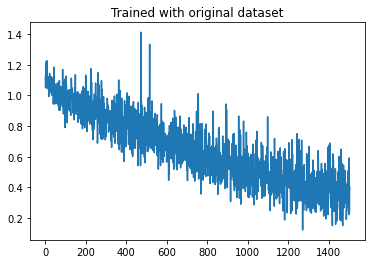

In [ ]:
from matplotlib import pyplot as plt
plt.plot(temp_losses)
plt.title("Trained with original dataset")
plt.show()

In [ ]:
import csv

with open("/content/drive/MyDrive/data/TACO/efficientNet_finetuned_loss.csv", 'w') as f:

    # using csv.writer method from CSV package
    write = csv.writer(f)
    for loss in train_losses:
        write.writerow([loss])

### Load Loss

In [ ]:
import csv

with open('/content/drive/MyDrive/data/TACO/efficientNet_finetuned_loss.csv', newline='') as f:
    reader = csv.reader(f)
    temp_losses = []
    for row in reader:
        temp_losses.append(float(row[0]))
    print(len(temp_losses))

# temp_losses = temp_losses + train_losses
print(len(temp_losses))

1505
1505


# Save Model

In [ ]:
# save model
torch.save(model, "/content/drive/MyDrive/data/TACO/models/efficientNet_finetuned.pt")

# Validate Model

## Load Model

In [ ]:
%pip install torchinfo
import torch
from torchinfo import summary
import torch.cuda as cuda

if cuda.is_available():
    model = torch.load("/content/drive/MyDrive/data/TACO/models/efficientNet_finetuned.pt")
else:
    model = torch.load("/content/drive/MyDrive/data/TACO/models/efficientNet_finetuned.pt", map_location=torch.device('cpu'))

device = 'cuda' if cuda.is_available() else 'cpu'
model = model.to(device)
print(f"device: {device}")
# summary(model, (8,3,1024,1024))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
device: cpu


## Validate Model

### Training Set

In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn as nn
from math import ceil

BATCHSIZE = 16

transforms = T.Compose([T.ToTensor()])
dataset = TacoDataset(mode="train", transforms=transforms)
dataloader = DataLoader(dataset, BATCHSIZE)

NUM_BATCHES = ceil(len(dataset) / BATCHSIZE)
NUM_DATA = len(dataset)
print(f"# of batches: {NUM_BATCHES}")
print(f"# of data: {NUM_DATA}")

criterion = nn.CrossEntropyLoss(reduction='mean') # cross entropy loss function for classification
loss = 0
correct = 0
targets = []
outputs = []
mislabeled_datas = []

model.eval()
for b,(X,y) in enumerate(dataloader):
    with torch.no_grad():
        print(f"batch {b+1}/{NUM_BATCHES}")
        # send the data to device(gpu)
        X, y = X.to(device), y.to(device)

        # generate predictions and compute the loss
        y_pred = model(X)
        loss += criterion(y_pred,y).item()
        correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        # save y and y_pred (to be used in confusion matrix)
        outputs += y_pred.argmax(1).tolist()
        targets += y.tolist()

        # save y and y_pred (to be used in confusion matrix)
        outputs += y_pred.argmax(1).tolist()
        targets += y.tolist()

        # save index of mislabeled data
        mask = (y_pred.argmax(1) != y)
        mislabeled_data = X[mask,:]
        correct_label = y[mask]
        pred_label = y_pred.argmax(1)[mask]
        mislabeled_datas.append((mislabeled_data, correct_label, pred_label))

ave_loss = loss / NUM_BATCHES
accuracy = correct / NUM_DATA
print(f"Training Set loss = {ave_loss:0.4f}")
print(f"Training Set accuracy = {accuracy:0.4f}")

# of batches: 43
# of data: 678
batch 1/43
batch 2/43
batch 3/43
batch 4/43
batch 5/43
batch 6/43
batch 7/43
batch 8/43
batch 9/43
batch 10/43
batch 11/43
batch 12/43
batch 13/43
batch 14/43
batch 15/43
batch 16/43
batch 17/43
batch 18/43
batch 19/43
batch 20/43
batch 21/43
batch 22/43
batch 23/43
batch 24/43
batch 25/43
batch 26/43
batch 27/43
batch 28/43
batch 29/43
batch 30/43
batch 31/43
batch 32/43
batch 33/43
batch 34/43
batch 35/43
batch 36/43
batch 37/43
batch 38/43
batch 39/43
batch 40/43
batch 41/43
batch 42/43
batch 43/43
Training Set loss = 0.4098
Training Set accuracy = 0.8643


### Training Set Confusion Matrix

In [ ]:
num_mislabeled = 0
for i in mislabeled_datas:
    num_mislabeled += len(i[1])
    print(f"# of mislabeled data in batch = {len(i[1])}")
print(f"Total number of mislabeled data = {num_mislabeled}")

# of mislabeled data in batch = 0
# of mislabeled data in batch = 1
# of mislabeled data in batch = 1
# of mislabeled data in batch = 3
# of mislabeled data in batch = 0
# of mislabeled data in batch = 1
# of mislabeled data in batch = 1
# of mislabeled data in batch = 1
# of mislabeled data in batch = 1
# of mislabeled data in batch = 0
# of mislabeled data in batch = 0
# of mislabeled data in batch = 0
# of mislabeled data in batch = 2
# of mislabeled data in batch = 1
# of mislabeled data in batch = 2
# of mislabeled data in batch = 0
# of mislabeled data in batch = 2
# of mislabeled data in batch = 0
# of mislabeled data in batch = 0
# of mislabeled data in batch = 0
# of mislabeled data in batch = 2
# of mislabeled data in batch = 4
# of mislabeled data in batch = 4
# of mislabeled data in batch = 3
# of mislabeled data in batch = 4
# of mislabeled data in batch = 2
# of mislabeled data in batch = 2
# of mislabeled data in batch = 0
# of mislabeled data in batch = 5
# of mislabele

In [ ]:
from sklearn import metrics

print(metrics.classification_report(targets, outputs))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       658
           1       0.94      0.80      0.87       410
           2       0.84      0.76      0.80       288

    accuracy                           0.86      1356
   macro avg       0.87      0.84      0.85      1356
weighted avg       0.87      0.86      0.86      1356



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# constant for classes
classes = ('Bottle', 'Can', 'Cup')

# Build confusion matrix
cf_matrix = confusion_matrix(targets, outputs)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

### Test Set

In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn as nn
from math import ceil

BATCHSIZE = 16

transforms = T.Compose([T.Resize((300,300))
                       ,T.ToTensor()])
dataset = TacoDataset(mode="test", transforms=transforms)
dataloader = DataLoader(dataset, BATCHSIZE)

NUM_BATCHES = ceil(len(dataset) / BATCHSIZE)
NUM_DATA = len(dataset)
print(f"# of batches: {NUM_BATCHES}")
print(f"# of data: {NUM_DATA}")

criterion = nn.CrossEntropyLoss(reduction = "mean") # cross entropy loss function for classification
loss = 0
correct = 0
test_targets = []
test_outputs = []
mislabeled_datas = []

model.eval()
for b,(X,y) in enumerate(dataloader):
    with torch.no_grad():
        print(f"batch {b+1}/{NUM_BATCHES}")
        # send the data to device(gpu)
        X, y = X.to(device), y.to(device)

        # generate predictions and compute the loss
        y_pred = model(X)
        loss += criterion(y_pred,y).item()
        correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        # save y and y_pred (to be used in confusion matrix)
        test_outputs += y_pred.argmax(1).tolist()
        test_targets += y.tolist()

        # save index of mislabeled data
        mask = (y_pred.argmax(1) != y)
        mislabeled_data = X[mask,:]
        correct_label = y[mask]
        pred_label = y_pred.argmax(1)[mask]
        mislabeled_datas.append((mislabeled_data, correct_label, pred_label))

ave_loss = loss / NUM_BATCHES
accuracy = correct / NUM_DATA
print(f"Test Set loss = {ave_loss:0.4f}")
print(f"Test Set accuracy = {accuracy:0.4f}")

# of batches: 15
# of data: 226
batch 1/15
batch 2/15
batch 3/15
batch 4/15
batch 5/15
batch 6/15
batch 7/15
batch 8/15
batch 9/15
batch 10/15
batch 11/15
batch 12/15
batch 13/15
batch 14/15
batch 15/15
Test Set loss = 0.4310
Test Set accuracy = 0.8319


In [ ]:
num_mislabeled = 0
for i in mislabeled_datas:
    num_mislabeled += len(i[1])
    print(f"# of mislabeled data in batch = {len(i[1])}")
print(f"Total number of mislabeled data = {num_mislabeled}")

# of mislabeled data in batch = 0
# of mislabeled data in batch = 0
# of mislabeled data in batch = 2
# of mislabeled data in batch = 0
# of mislabeled data in batch = 0
# of mislabeled data in batch = 1
# of mislabeled data in batch = 2
# of mislabeled data in batch = 3
# of mislabeled data in batch = 8
# of mislabeled data in batch = 2
# of mislabeled data in batch = 3
# of mislabeled data in batch = 7
# of mislabeled data in batch = 7
# of mislabeled data in batch = 2
# of mislabeled data in batch = 1
Total number of mislabeled data = 38


In [ ]:
fig, axes = plt.subplots(8,5, figsize=(50,100))
row = 0
col = 0
for i, (imgs, targets, preds) in enumerate(mislabeled_datas):
    for j in range(len(targets)):
        img, target, pred = imgs[j].cpu(), targets[j].item(), preds[j].item()
        target_name = test_dataset.cat_id2name[test_dataset.cat_id2name['supercat_id'] == target].supercategory.item()
        pred_name = test_dataset.cat_id2name[test_dataset.cat_id2name['supercat_id'] == pred].supercategory.item()
        axes[row][col].imshow(img.permute(1,2,0))
        axes[row][col].set_title(f"Target:{target_name} | Pred:{pred_name}")

        col += 1
        if col == 5:
            row += 1
            col = 0

plt.tight_layout()
plt.show()

## Test Set Confusion Matrix

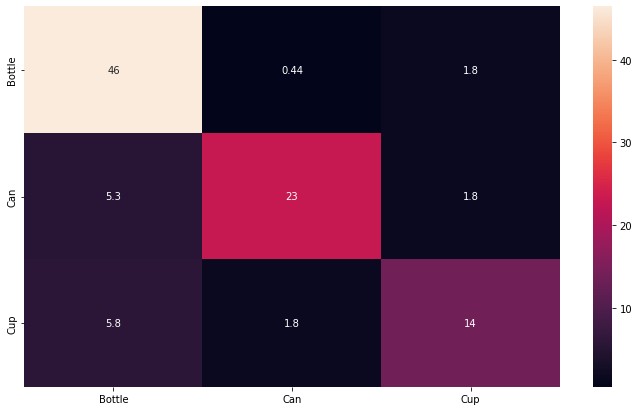

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# constant for classes
classes = ('Bottle', 'Can', 'Cup')

# Build confusion matrix
test_cf_matrix = confusion_matrix(test_targets, test_outputs)
df_cm_test = pd.DataFrame(test_cf_matrix/np.sum(test_cf_matrix) *100, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm_test, annot=True)
plt.savefig('output.png')

In [ ]:
from sklearn import metrics

print(metrics.classification_report(test_targets, test_outputs))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88       110
           1       0.91      0.76      0.83        68
           2       0.79      0.65      0.71        48

    accuracy                           0.83       226
   macro avg       0.84      0.79      0.81       226
weighted avg       0.84      0.83      0.83       226

